# Limpieza de Datos – Proyecto 'Explorando el Éxito Académico'
Este notebook documenta la limpieza y procesamiento de datos del proyecto que busca predecir estudiantes en riesgo de deserción académica.

## Inicializacion de la Notebook

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Mostrar todas las columnas
pd.set_option('display.max_columns', None)

print('Librerias importadas.')

Librerias importadas.


### Diccionarios a Utilizar

In [10]:
# Diccionario de mapeo de Semestre
mapa_semestre = {
    1: 'Enero - Junio',
    2: 'Verano',
    3: 'Agosto - Diciembre'
}

# Diccionario de mapeo de Calificacion
mapa_calificacion = {
    1: "Calificación Ordinario",
    2: "Calificación Recuperación",
    3: "Calificación de Extraordinario del Curso Ordinario",
    4: "Calificación Ordinaria Curso RC",
    5: "Calificación Recuperación Curso RC"
}

# Diccionario para interpretar la prediccion numerica
interpretacion_causa = {
    1: 'Cursando',
    2: 'Baja Temporal',
    3: 'Baja por Especial',
    4: 'Baja Definitiva',
    5: 'Egresado'
}

### Carga de Datos

In [11]:
estudiantes = pd.read_csv('data/estudiantes.csv')
escuelas = pd.read_csv('data/escuelas.csv')
carreras = pd.read_csv('data/carrera.csv')
calificaciones = pd.read_csv('data/calificaciones.csv')
mapa_ciudades_df = pd.read_csv('data/mapa_ciudades.csv')

print('Datos cargados.')

Datos cargados.


## Limpieza y Preprocesado de Datos

### Limpieza de Datos

In [12]:
# ------------ Limpieza de Valores Nulos ------------
# estudiantes = estudiantes.dropna(subset=['clave_alumno', 'clave_carrera', 'ingreso', 'termino'])
# calificaciones = calificaciones.dropna(subset=['clave_alumno', 'periodo', 'calificacion'])
# print('Valores nulos eliminados.')

# ------------ Eliminar columnas no necesarias ------------
if 'municipio' in estudiantes.columns:
    estudiantes = estudiantes.drop(['municipio'], axis=1)
print('Columnas no necesarias eliminadas.')

# ------------ Reemplazo de valores problemáticos ------------
# Convertir ingreso a numérico, valores no válidos serán NaN
if 'ingreso' in estudiantes.columns:
  estudiantes['ingreso'] = pd.to_numeric(estudiantes['ingreso'], errors='coerce')
  # Reemplazar NaN con 0
  estudiantes['ingreso'] = estudiantes['ingreso'].fillna(0).astype(int)

if 'termino' in estudiantes.columns:
  # Rellenar NaN en 'termino'
  estudiantes['termino'] = estudiantes['termino'].fillna(0).astype(int)

# Rellenar posibles NaN en columnas resumen (comentado)
# estudiantes['promedio'] = estudiantes['promedio'].fillna(0)
# estudiantes['materias_totales'] = estudiantes['materias_totales'].fillna(0).astype(int)
# estudiantes['materias_reprobadas'] = estudiantes['materias_reprobadas'].fillna(0).astype(int)

# Filtrar calificaciones solo para alumnos válidos
calificaciones = calificaciones[calificaciones['clave_alumno'].isin(estudiantes['clave_alumno'])]

print('Limpieza de datos finalizada.')

Columnas no necesarias eliminadas.
Limpieza de datos finalizada.


### Preprocesado de Datos General

In [13]:
# ------------ Conversion de tipos ------------
# Estudiantes
estudiantes['clave_alumno'] = estudiantes['clave_alumno'].astype(int)
# Calificaciones
calificaciones['clave_alumno'] = calificaciones['clave_alumno'].astype(int)
# calificaciones['periodo'] = calificaciones['periodo'].astype(int)

print('Tipos de datos convertidos.')

# ------------ Verificacion de claves únicas ------------
assert estudiantes['clave_alumno'].is_unique

# ------------ Enriquecimiento de datos ------------
# Contar número de calificaciones por alumno
calif_counts = calificaciones['clave_alumno'].value_counts()
estudiantes['num_calificaciones'] = estudiantes['clave_alumno'].map(calif_counts).fillna(0).astype(int)

print(f"Estudiantes con calificaciones (validos): {calificaciones['clave_alumno'].nunique()} de {estudiantes['clave_alumno'].nunique()}.")

# ------------ Analisis de causa_salida ------------
print('\n\nCantidad de alumnos con cada causa de salida:')
for clase in [1, 2, 3, 4, 5]:
    alumnos_clase = estudiantes[estudiantes['causa_salida'] == clase]['clave_alumno']
    cantidad = calificaciones[calificaciones['clave_alumno'].isin(alumnos_clase)]['clave_alumno'].nunique()
    print(f"Causa salida {clase}: {cantidad} alumnos con calificaciones")

Tipos de datos convertidos.
Estudiantes con calificaciones (validos): 11726 de 11936.


Cantidad de alumnos con cada causa de salida:
Causa salida 1: 3972 alumnos con calificaciones
Causa salida 2: 346 alumnos con calificaciones
Causa salida 3: 836 alumnos con calificaciones
Causa salida 4: 2859 alumnos con calificaciones
Causa salida 5: 3713 alumnos con calificaciones


### Preprocesado del DataFrame `estudiantes`

In [14]:
if 'ingreso' in estudiantes.columns:
  # Asegurar que ingreso es numérico, reemplazar no válidos con 0
  estudiantes['ingreso'] = pd.to_numeric(estudiantes['ingreso'], errors='coerce').fillna(0).astype(int)

  # Crear máscara para ingresos válidos (número >= 1000 para asegurar 4 cifras mínimo)
  mask_ingreso_validos = estudiantes['ingreso'] >= 1000

  # Inicializar columnas
  estudiantes.loc[:, 'year_ingreso'] = 0
  estudiantes.loc[:, 'semestre_ingreso_numero'] = 0
  estudiantes.loc[:, 'semestre_ingreso_nombre'] = 'Desconocido'

  # Extraer año y semestre en filas válidas
  ingreso_validos = estudiantes.loc[mask_ingreso_validos, 'ingreso']
  estudiantes.loc[mask_ingreso_validos, 'year_ingreso'] = (ingreso_validos // 10) % 100 + 2000
  estudiantes.loc[mask_ingreso_validos, 'semestre_ingreso_numero'] = ingreso_validos % 10

  # Mapear semestre a nombre
  estudiantes.loc[mask_ingreso_validos, 'semestre_ingreso_nombre'] = (
      estudiantes.loc[mask_ingreso_validos, 'semestre_ingreso_numero']
      .map(mapa_semestre)
      .fillna('Desconocido')
  )

  # Eliminar columna `ingreso`
  estudiantes = estudiantes.drop(columns=['ingreso'])

if 'termino' in estudiantes.columns:
    # Eliminar filas con 'termino' NaN y hacer copia para evitar vista
    estudiantes = estudiantes.dropna(subset=['termino']).copy()

    # Asegurar que termino es string y quitar espacios
    estudiantes.loc[:, 'termino'] = estudiantes['termino'].astype(str).str.strip()

    # Reemplazar valores problemáticos por NaN
    estudiantes.loc[:, 'termino'] = estudiantes['termino'].replace(['', 'nan', 'None'], np.nan)

    # Crear máscara para filas con termino válido (longitud >= 4)
    mask_termino_validos = estudiantes['termino'].notna() & (estudiantes['termino'].str.len() >= 4)

    # Inicializar columnas con valores por defecto usando loc
    estudiantes.loc[:, 'year_termino'] = 0
    estudiantes.loc[:, 'semestre_termino_numero'] = 0
    estudiantes.loc[:, 'semestre_termino_nombre'] = 'Desconocido'

    # Calcular year_termino solo en filas válidas
    estudiantes.loc[mask_termino_validos, 'year_termino'] = (
        estudiantes.loc[mask_termino_validos, 'termino'].str[1:3].astype(int) + 2000
    )

    # Calcular semestre_termino_numero solo en filas válidas
    estudiantes.loc[mask_termino_validos, 'semestre_termino_numero'] = (
        estudiantes.loc[mask_termino_validos, 'termino'].str[3].astype(int)
    )

    # Forzar tipo int para evitar problemas de mapeo
    estudiantes.loc[mask_termino_validos, 'semestre_termino_numero'] = estudiantes.loc[mask_termino_validos, 'semestre_termino_numero'].astype(int)

    # Mapear semestre_termino_nombre para filas válidas
    estudiantes.loc[mask_termino_validos, 'semestre_termino_nombre'] = estudiantes.loc[mask_termino_validos, 'semestre_termino_numero']\
        .map(mapa_semestre).fillna('Desconocido')

    # Eliminar columna `termino`
    estudiantes = estudiantes.drop(columns=['termino'])

# Normalizar la columna `ciudades`
estudiantes['ciudad'] = estudiantes['ciudad'].str.upper() # Convertir a Mayusculas
estudiantes['ciudad'] = estudiantes['ciudad'].str.strip() # Quitar espacios al inicio y final
estudiantes['ciudad'] = estudiantes['ciudad'].str.replace(r'[.,]', '', regex=True) # Quitar caracteres raros
mapa_ciudades = dict(zip(mapa_ciudades_df['original'], mapa_ciudades_df['estandarizado'])) # Crear diccionario usando el DataFrame `mapa_ciudades_df`
estudiantes['ciudad'] = estudiantes['ciudad'].replace(mapa_ciudades) # Aplicar mapeo para estandarizar

# Agregar columna `genero` en base a `sexo`
estudiantes['genero'] = estudiantes['sexo'].map({1: 'Masculino', 2: 'Femenino'})

# Cambiar nombre a columnas
estudiantes = estudiantes.rename(columns={
    'prepa': 'clave_prepa',
    'num_calificaciones': 'cant_calificaciones',
})

# Agregar columna `causa_salida_nombre` en base a `causa_salida`
estudiantes['causa_salida_nombre'] = estudiantes['causa_salida'].map(interpretacion_causa)

# Ordenar DataFrame
estudiantes = estudiantes[[
    'clave_alumno',
    'clave_carrera',
    'genero',
    'sexo',
    'clave_prepa',
    'colonia',
    'ciudad',
    'year_ingreso',
    'semestre_ingreso_numero',
    'semestre_ingreso_nombre',
    'year_termino',
    'semestre_termino_numero',
    'semestre_termino_nombre',
    'cant_calificaciones',
    'causa_salida_nombre',
    'causa_salida'
]]

print('Preprocesamiento de datos del DataFrame `estudiantes` finalizado.')


Preprocesamiento de datos del DataFrame `estudiantes` finalizado.


/tmp/ipykernel_6242/2961104029.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['2061' '2061' '2061' ... '0' '0' '2103']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  estudiantes.loc[:, 'termino'] = estudiantes['termino'].astype(str).str.strip()


In [15]:
# Visualizar el DataFrame estudiantes
estudiantes

,clave_alumno,clave_carrera,genero,sexo,clave_prepa,colonia,ciudad,year_ingreso,semestre_ingreso_numero,semestre_ingreso_nombre,year_termino,semestre_termino_numero,semestre_termino_nombre,cant_calificaciones,causa_salida_nombre,causa_salida
0,28,4,Masculino,1,2,Los Angeles,CULIACAN,2000,3,Agosto - Diciembre,2006,1,Enero - Junio,62,Egresado,5
1,248,4,Masculino,1,125,FRAC.RINCON HYA,CULIACAN,2000,3,Agosto - Diciembre,2006,1,Enero - Junio,56,Egresado,5
2,260,4,Masculino,1,71,El Walamo,CULIACAN,2000,3,Agosto - Diciembre,2006,1,Enero - Junio,61,Egresado,5
3,261,4,Masculino,1,107,4 de Marzo,CULIACAN,2000,3,Agosto - Diciembre,2005,1,Enero - Junio,46,Baja Definitiva,4
4,262,4,Femenino,2,2,Los Angeles,CULIACAN,2000,3,Agosto - Diciembre,2005,3,Agosto - Diciembre,55,Egresado,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11931,11739,8,Masculino,1,91,LA,CULIACAN,2010,3,Agosto - Diciembre,0,0,Desconocido,6,Cursando,1
11932,11740,8,Masculino,1,71,BALCONES,CULIACAN,2010,3,Agosto - Diciembre,0,0,Desconocido,5,Cursando,1
11933,11825,8,Masculino,1,26,San Miguel,CULIACAN,2010,3,Agosto - Diciembre,0,0,Desconocido,5,Cursando,1
11934,11831,8,Masculino,1,70,ADOLFO,CULIACAN,2010,3,Agosto - Diciembre,0,0,Desconocido,6,Cursando,1


### Preprocesado del DataFrame `calificaciones`

In [16]:
if 'periodo' in calificaciones.columns:
  # Convertir a string por si acaso
  calificaciones['periodo'] = calificaciones['periodo'].astype(str)

  # Obtener el año (dos digitos despues del primer caracter)
  calificaciones['periodo_year'] = calificaciones['periodo'].str[1:3].astype(int) + 2000

  # Obtener numero de semestre
  calificaciones['periodo_semestre_numero'] = calificaciones['periodo'].str[-1].astype(int)

  # Obtener nombre del semestre
  calificaciones['periodo_semestre_numero'] = calificaciones['periodo'].str[-1].astype(int)

  # Eliminar columna `periodo`
  calificaciones = calificaciones.drop(columns=['periodo'])

# Mapear `tipo_calificacion` a `descripcion_calificacion`
calificaciones['descripcion_calificacion'] = calificaciones['tipo_calificacion'].map(mapa_calificacion)

# Mapear `periodo_semestre_nombre` a String
calificaciones['periodo_semestre_nombre'] = calificaciones['periodo_semestre_numero'].map(mapa_semestre)

# Ordenar DataFrame
calificaciones = calificaciones[[
    'clave_alumno',
    'clave_materia',
    'tipo_calificacion',
    'descripcion_calificacion',
    'calificacion',
    'periodo_year',
    'periodo_semestre_numero',
    'periodo_semestre_nombre'
]]

print('Preprocesamiento de datos del DataFrame `calificaciones` finalizado.')

Preprocesamiento de datos del DataFrame `calificaciones` finalizado.


In [17]:
calificaciones

,clave_alumno,clave_materia,tipo_calificacion,descripcion_calificacion,calificacion,periodo_year,periodo_semestre_numero,periodo_semestre_nombre
10,4819,ACH9322,3,Calificación de Extraordinario del Curso Ordin...,0.0,2000,3,Agosto - Diciembre
11,4819,ACB9309,3,Calificación de Extraordinario del Curso Ordin...,0.0,2000,3,Agosto - Diciembre
12,4819,ACC9326,3,Calificación de Extraordinario del Curso Ordin...,0.0,2000,3,Agosto - Diciembre
13,4819,ACB9339,1,Calificación Ordinario,80.0,2000,3,Agosto - Diciembre
14,4819,ACM9301,3,Calificación de Extraordinario del Curso Ordin...,0.0,2000,3,Agosto - Diciembre
...,...,...,...,...,...,...,...,...
374721,11853,ACA0907,1,Calificación Ordinario,80.0,2010,3,Agosto - Diciembre
374722,11853,ACC0906,1,Calificación Ordinario,95.0,2010,3,Agosto - Diciembre
374723,11853,ACF0901,1,Calificación Ordinario,95.0,2010,3,Agosto - Diciembre
374724,11853,INC1033,1,Calificación Ordinario,75.0,2010,3,Agosto - Diciembre


### Preprocesado del DataFrame `carreras`

In [18]:
# Eliminar columnas no necesarias
if 'nombre' in carreras.columns:
    carreras = carreras.drop(columns=['nombre'])

# Renombrar columnas
carreras = carreras.rename(columns={
    'corto': 'nombre_carrera',
    }
)

print('Preprocesamiento de datos del DataFrame `carreras` finalizado.')

Preprocesamiento de datos del DataFrame `carreras` finalizado.


In [19]:
carreras

,clave_carrera,nombre_carrera
0,0,Industrial
1,1,Bioquimica
2,2,Mecanica
3,3,Electrica
4,4,Electronica
5,5,Informatica
6,6,Sistemas
7,7,Mecatronica
8,8,TIC


### Preprocesamiento del DataFrame `escuelas`

In [20]:
# Renombrar columnas
escuelas = escuelas.rename(columns={
    'clave': 'clave_prepa',
    'escuela': 'nombre_prepa',
    }
)

In [21]:
escuelas

,clave_prepa,nombre_prepa
0,3,COBAES 3(PROFRA. VELINA LEON )
1,4,COBAES 4(PROFR. VICTOR M. RUB)
2,5,COBAES 5(PROFRA. FCA. GUERRER)
3,6,COBAES 6(ING.JOSE HERNANDEZ T)
4,7,COBAES 7(GRAÑ. PABLO MACIAS V)
...,...,...
355,690,UAS (PREPARATORIA LAZARO CARDENAS)
356,693,COBAES 94 (EL SALADO)
357,696,(UAS) PREPARATORIA CASA BLANCA EXT. EL PROGRESO
358,699,UAS (PREPARATORIA POTRERILLOS)


## Unificacion de Datos

In [22]:
# 1. Calcular resumen de calificaciones por alumno (sin cant_materias_calificadas)
umbral_reprobado = 60

resumen_calificaciones = calificaciones.groupby('clave_alumno').agg(
    promedio_calificacion = ('calificacion', 'mean'),
    cant_materias_reprobadas = ('calificacion', lambda x: (x < umbral_reprobado).sum())
).reset_index()

# Opcional: reemplazar NaN por 0 para alumnos sin calificaciones
resumen_calificaciones[['promedio_calificacion', 'cant_materias_reprobadas']] = \
    resumen_calificaciones[['promedio_calificacion', 'cant_materias_reprobadas']].fillna(0)

# 2. Unir `estudiantes` con `carreras`
df = estudiantes.merge(carreras, on='clave_carrera', how='left')

# 3. Unir con `escuelas` usando la clave_prepa
df = df.merge(escuelas, left_on='clave_prepa', right_on='clave_prepa', how='left')

# 4. Unir el resumen de calificaciones (solo promedio y reprobadas)
df = df.merge(resumen_calificaciones, on='clave_alumno', how='left')

# Reemplazar NaN en resumen de calificaciones por 0 en caso de alumnos sin calificaciones
df[['promedio_calificacion', 'cant_materias_reprobadas']] = \
    df[['promedio_calificacion', 'cant_materias_reprobadas']].fillna(0)

# Reemplazar NaN en la columna `nombre_prepa` con 'Desconocido'
df['nombre_prepa'] = df['nombre_prepa'].fillna('Desconocido')

# Asegurar que promedio_calificacion sea float con 2 decimales
df['promedio_calificacion'] = df['promedio_calificacion'].astype(float).round(2)

df['cant_materias_reprobadas'] = df['cant_materias_reprobadas'].astype(int)

# Ordenar DataFrame
df = df[[
  'clave_alumno',             # Identificacion alumno
  'clave_carrera',            # Clave carrera
  'nombre_carrera',           # Nombre de la carrera
  'sexo',                     # Clave de Sexo
  'genero',                   # Genero
  'clave_prepa',              # Clave de la prepa
  'nombre_prepa',             # Nombre de la prepa
  'colonia',                  # Ubicación - colonia
  'ciudad',                   # Ubicación - ciudad
  'year_ingreso',             # Año de ingreso
  'semestre_ingreso_numero',  # Número semestre ingreso
  'semestre_ingreso_nombre',  # Nombre semestre ingreso
  'year_termino',             # Año término
  'semestre_termino_numero',  # Número semestre término
  'semestre_termino_nombre',  # Nombre semestre término
  'cant_calificaciones',      # Cantidad de materias calificadas
  'promedio_calificacion',    # Promedio de calificaciones
  'cant_materias_reprobadas', # Cantidad materias reprobadas
  'causa_salida_nombre',      # Motivo de causa de salida del alumno
  'causa_salida'              # Causa de salida del alumno
]]

print('Unificación de datos finalizada.')

Unificación de datos finalizada.


In [23]:
df

,clave_alumno,clave_carrera,nombre_carrera,sexo,genero,clave_prepa,nombre_prepa,colonia,ciudad,year_ingreso,semestre_ingreso_numero,semestre_ingreso_nombre,year_termino,semestre_termino_numero,semestre_termino_nombre,cant_calificaciones,promedio_calificacion,cant_materias_reprobadas,causa_salida_nombre,causa_salida
0,28,4,Electronica,1,Masculino,2,Desconocido,Los Angeles,CULIACAN,2000,3,Agosto - Diciembre,2006,1,Enero - Junio,62,68.68,8,Egresado,5
1,248,4,Electronica,1,Masculino,125,UAS (8 DE JULIO EL TAMARINDO),FRAC.RINCON HYA,CULIACAN,2000,3,Agosto - Diciembre,2006,1,Enero - Junio,56,61.45,14,Egresado,5
2,260,4,Electronica,1,Masculino,71,CONALEP (CULIACAN II),El Walamo,CULIACAN,2000,3,Agosto - Diciembre,2006,1,Enero - Junio,61,58.00,16,Egresado,5
3,261,4,Electronica,1,Masculino,107,C.B.T.I.S. 224,4 de Marzo,CULIACAN,2000,3,Agosto - Diciembre,2005,1,Enero - Junio,46,59.37,12,Baja Definitiva,4
4,262,4,Electronica,2,Femenino,2,Desconocido,Los Angeles,CULIACAN,2000,3,Agosto - Diciembre,2005,3,Agosto - Diciembre,55,73.15,6,Egresado,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11931,11739,8,TIC,1,Masculino,91,ITESM CAMPUS SINALOA,LA,CULIACAN,2010,3,Agosto - Diciembre,0,0,Desconocido,6,71.50,1,Cursando,1
11932,11740,8,TIC,1,Masculino,71,CONALEP (CULIACAN II),BALCONES,CULIACAN,2010,3,Agosto - Diciembre,0,0,Desconocido,5,54.60,2,Cursando,1
11933,11825,8,TIC,1,Masculino,26,COBAES 26(GRAL. ANGEL FLORES),San Miguel,CULIACAN,2010,3,Agosto - Diciembre,0,0,Desconocido,5,48.00,2,Cursando,1
11934,11831,8,TIC,1,Masculino,70,CONALEP I (JUAN DE DIOS BATIZ- CULIACAN),ADOLFO,CULIACAN,2010,3,Agosto - Diciembre,0,0,Desconocido,6,57.50,2,Cursando,1


## Graficas

### Distribucion de Estudiantes por Genero

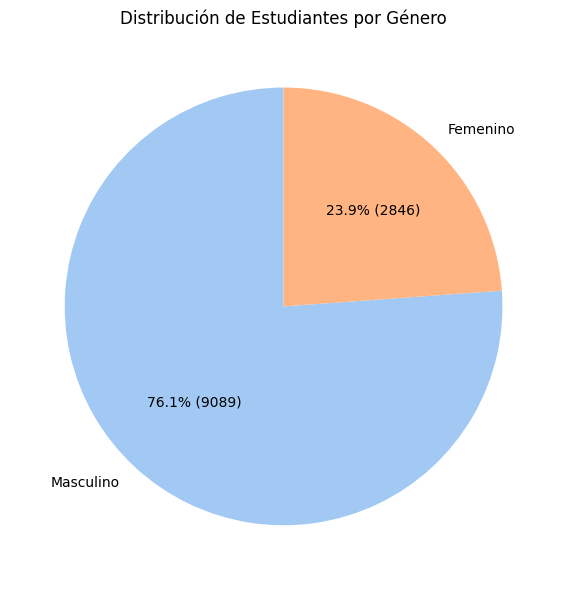

In [24]:
# Contar estudiantes por género
conteo_genero = df['genero'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(
    conteo_genero,
    labels=conteo_genero.index,
    autopct=lambda pct: f'{pct:.1f}% ({int(pct * conteo_genero.sum() / 100)})',
    colors=sns.color_palette('pastel'),
    startangle=90
)
plt.title('Distribución de Estudiantes por Género')
plt.tight_layout()
plt.show()

### Promedio de Calificaciones por Genero

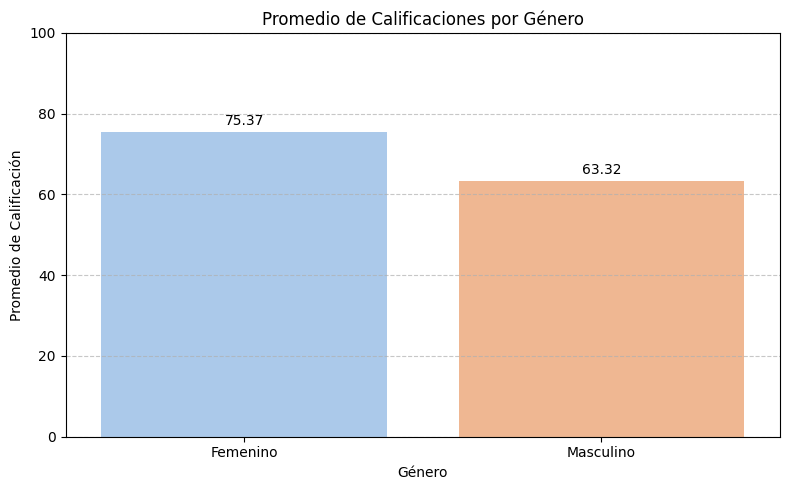

In [25]:
# Calcular promedio por género
promedios_por_genero = df.groupby('genero')['promedio_calificacion'].mean().reset_index()

# Redondear a 2 decimales
promedios_por_genero['promedio_calificacion'] = promedios_por_genero['promedio_calificacion'].round(2)

# Crear la gráfica
plt.figure(figsize=(8, 5))
sns.barplot(data=promedios_por_genero, x='genero', y='promedio_calificacion', palette='pastel', hue='genero', legend=False)

plt.title('Promedio de Calificaciones por Género')
plt.xlabel('Género')
plt.ylabel('Promedio de Calificación')
plt.ylim(0, 100)  # Opcional, para normalizar el eje Y
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar etiquetas encima de las barras
for index, row in promedios_por_genero.iterrows():
    plt.text(index, row['promedio_calificacion'] + 1, f"{row['promedio_calificacion']}",
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### Reprobacion por Carrera

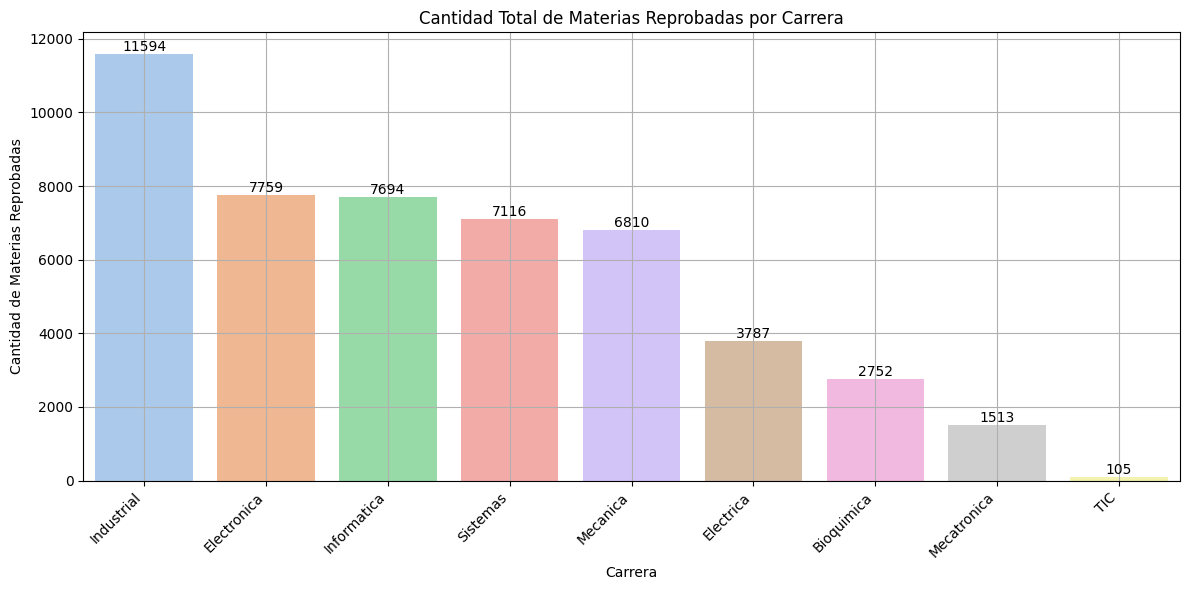

In [26]:
# Agrupar por carrera y sumar la cantidad de materias reprobadas
reprobacion_por_carrera = df.groupby('nombre_carrera')['cant_materias_reprobadas'].sum().reset_index()

# Ordenar de mayor a menor reprobación
reprobacion_por_carrera = reprobacion_por_carrera.sort_values(by='cant_materias_reprobadas', ascending=False)

plt.figure(figsize=(12,6))
barplot = sns.barplot(data=reprobacion_por_carrera, x='nombre_carrera', y='cant_materias_reprobadas', palette='pastel', hue='nombre_carrera')
plt.xticks(rotation=45, ha='right')
plt.title('Cantidad Total de Materias Reprobadas por Carrera')
plt.xlabel('Carrera')
plt.ylabel('Cantidad de Materias Reprobadas')
plt.grid(True)

# Mostrar etiquetas encima de las barras
for bar in barplot.patches:
    height = bar.get_height()
    barplot.text(
        bar.get_x() + bar.get_width() / 2,  # posición horizontal en el centro de la barra
        height,                            # posición vertical justo arriba de la barra
        f'{int(height)}',                  # texto (cantidad reprobadas, sin decimales)
        ha='center',                      # alinear horizontalmente al centro
        va='bottom'                       # alinear verticalmente abajo para que el texto quede encima de la barra
    )

plt.tight_layout()
plt.show()

### Promedio de Calificaciones por Carrera

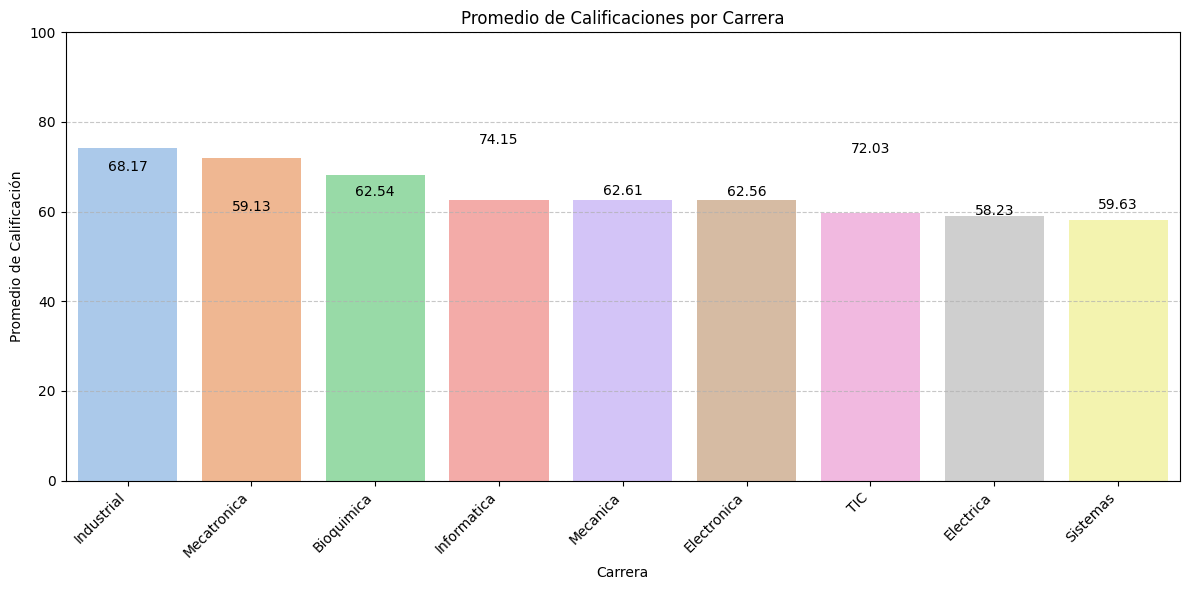

In [27]:
# Calcular promedio de calificaciones por carrera
promedio_por_carrera = df.groupby('nombre_carrera')['promedio_calificacion'].mean().reset_index()

# Ordenar de mayor a menor promedio
promedio_por_carrera = promedio_por_carrera.sort_values(by='promedio_calificacion', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(data=promedio_por_carrera, x='nombre_carrera', y='promedio_calificacion', palette='pastel', hue='nombre_carrera')

plt.xticks(rotation=45, ha='right')
plt.title('Promedio de Calificaciones por Carrera')
plt.xlabel('Carrera')
plt.ylabel('Promedio de Calificación')
plt.ylim(0, 100)  # Asumiendo calificaciones sobre 100
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar etiquetas encima de las barras
for index, row in promedio_por_carrera.iterrows():
    plt.text(index, row['promedio_calificacion'] + 1, f"{row['promedio_calificacion']:.2f}", ha='center')

plt.tight_layout()
plt.show()

### Distribucion de Estudiantes por Carrera

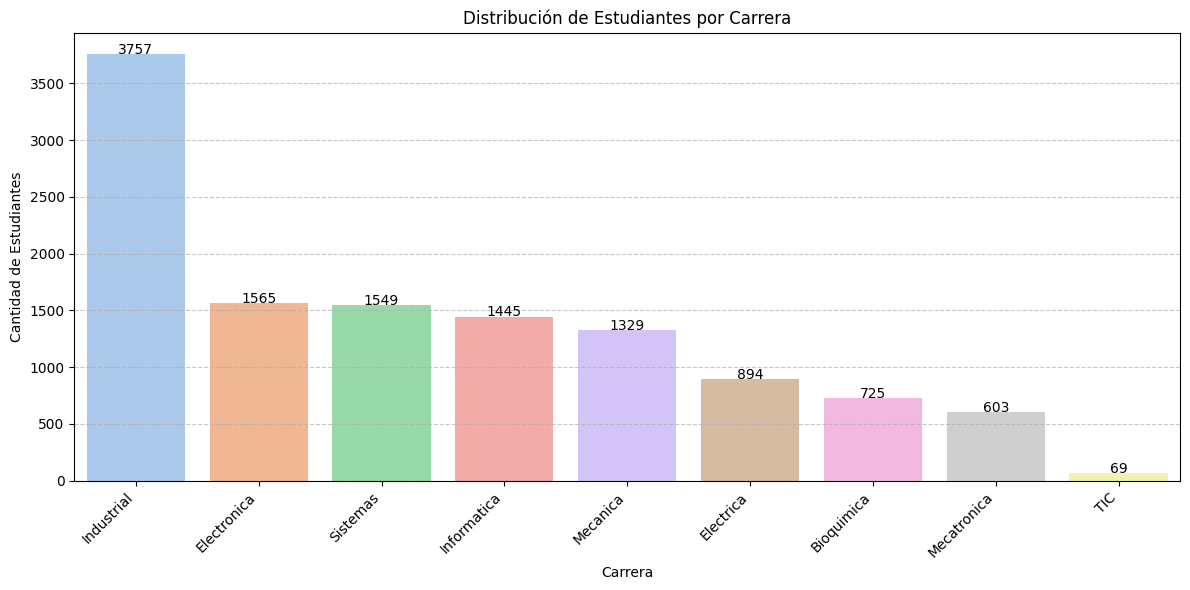

In [28]:
# Contar estudiantes por carrera
conteo_carreras = df['nombre_carrera'].value_counts().reset_index()
conteo_carreras.columns = ['nombre_carrera', 'cantidad_estudiantes']

plt.figure(figsize=(12,6))
sns.barplot(data=conteo_carreras, x='nombre_carrera', y='cantidad_estudiantes', palette='pastel', hue='nombre_carrera')

plt.xticks(rotation=45, ha='right')
plt.title('Distribución de Estudiantes por Carrera')
plt.xlabel('Carrera')
plt.ylabel('Cantidad de Estudiantes')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar etiquetas encima de las barras
for index, row in conteo_carreras.iterrows():
    plt.text(index, row['cantidad_estudiantes'] + 1, row['cantidad_estudiantes'], ha='center')

plt.tight_layout()
plt.show()

### Top 10 Carreras con Mayor Tasa de Aprobacion

In [29]:
df

,clave_alumno,clave_carrera,nombre_carrera,sexo,genero,clave_prepa,nombre_prepa,colonia,ciudad,year_ingreso,semestre_ingreso_numero,semestre_ingreso_nombre,year_termino,semestre_termino_numero,semestre_termino_nombre,cant_calificaciones,promedio_calificacion,cant_materias_reprobadas,causa_salida_nombre,causa_salida
0,28,4,Electronica,1,Masculino,2,Desconocido,Los Angeles,CULIACAN,2000,3,Agosto - Diciembre,2006,1,Enero - Junio,62,68.68,8,Egresado,5
1,248,4,Electronica,1,Masculino,125,UAS (8 DE JULIO EL TAMARINDO),FRAC.RINCON HYA,CULIACAN,2000,3,Agosto - Diciembre,2006,1,Enero - Junio,56,61.45,14,Egresado,5
2,260,4,Electronica,1,Masculino,71,CONALEP (CULIACAN II),El Walamo,CULIACAN,2000,3,Agosto - Diciembre,2006,1,Enero - Junio,61,58.00,16,Egresado,5
3,261,4,Electronica,1,Masculino,107,C.B.T.I.S. 224,4 de Marzo,CULIACAN,2000,3,Agosto - Diciembre,2005,1,Enero - Junio,46,59.37,12,Baja Definitiva,4
4,262,4,Electronica,2,Femenino,2,Desconocido,Los Angeles,CULIACAN,2000,3,Agosto - Diciembre,2005,3,Agosto - Diciembre,55,73.15,6,Egresado,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11931,11739,8,TIC,1,Masculino,91,ITESM CAMPUS SINALOA,LA,CULIACAN,2010,3,Agosto - Diciembre,0,0,Desconocido,6,71.50,1,Cursando,1
11932,11740,8,TIC,1,Masculino,71,CONALEP (CULIACAN II),BALCONES,CULIACAN,2010,3,Agosto - Diciembre,0,0,Desconocido,5,54.60,2,Cursando,1
11933,11825,8,TIC,1,Masculino,26,COBAES 26(GRAL. ANGEL FLORES),San Miguel,CULIACAN,2010,3,Agosto - Diciembre,0,0,Desconocido,5,48.00,2,Cursando,1
11934,11831,8,TIC,1,Masculino,70,CONALEP I (JUAN DE DIOS BATIZ- CULIACAN),ADOLFO,CULIACAN,2010,3,Agosto - Diciembre,0,0,Desconocido,6,57.50,2,Cursando,1


### Top 10 Carreras con Mayor Tasa de Reprobacion

### Top 10 Ciudades de Procedencia

### Cantidad de Estudiantes por Año de Ingreso

### Promedio de Calificaciones por Año de Ingreso

## Modelo